In [14]:
import matplotlib.pyplot as plt

from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from itertools import product
import numpy as np

from sklearn.svm import SVC

## Data Loading

In [15]:
X_toy, y_toy = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1,
                           class_sep=0.8, flip_y=0.05, random_state=42)

X_shuffled, y_shuffled = shuffle(X_toy, y_toy, random_state=42)

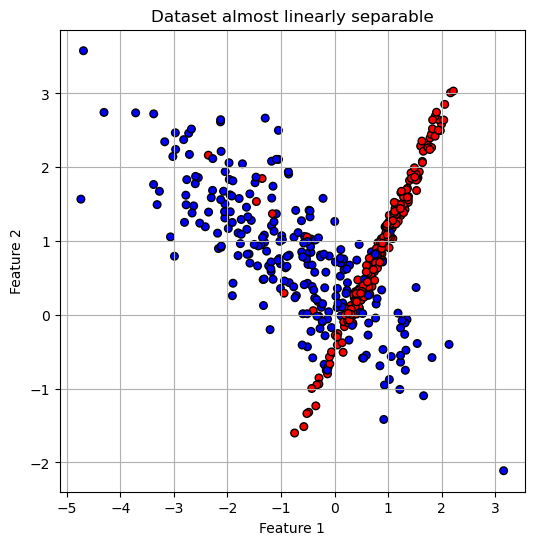

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(X_toy[:, 0], X_toy[:, 1], c=y_toy, cmap='bwr', edgecolor='k', s=30)
plt.title("Dataset almost linearly separable")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.show()

## Perceptron

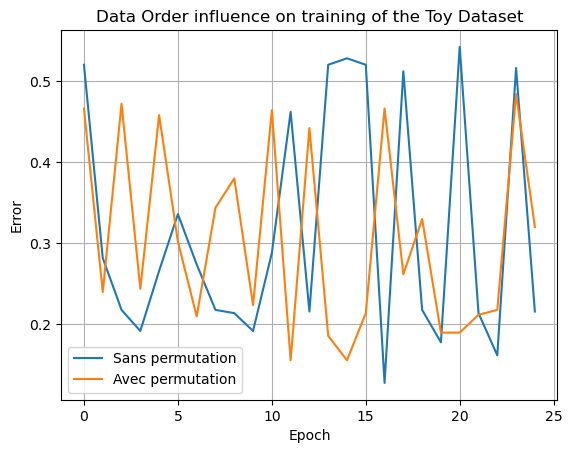

In [17]:
model_ordered = Perceptron(max_iter=1000, warm_start=True, random_state=42)
model_shuffled = Perceptron(max_iter=1000, warm_start=True, random_state=42)

n_epochs = 25
loss_ordered = []
loss_shuffled = []

def compute_error(model, X, y):
    return np.mean(model.predict(X) != y)

# train the models
for epoch in range(n_epochs):
    model_ordered.fit(X_toy, y_toy)
    model_shuffled.fit(X_shuffled, y_shuffled)
    
    loss_ordered.append(compute_error(model_ordered, X_toy, y_toy))
    loss_shuffled.append(compute_error(model_shuffled, X_toy, y_toy))

plt.plot(loss_ordered, label='Sans permutation')
plt.plot(loss_shuffled, label='Avec permutation')
plt.xlabel('Epoch')
plt.ylabel("Error")
plt.title("Data Order influence on training of the Toy Dataset")
plt.legend()
plt.grid(True)
plt.show()

# Analyse

## (0) Base Case

Let's try as the Vanilla Base Case: Train on the entire dataset using uniform random shuffling for each epoch.

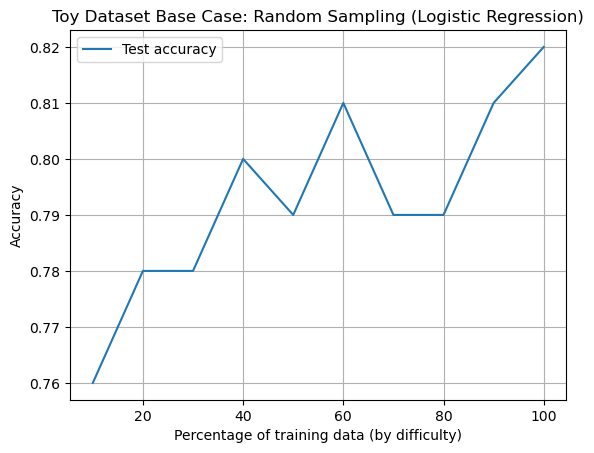

In [33]:
X_train_toy, X_test_toy, y_train_toy, y_test_toy = train_test_split(X_toy, y_toy, test_size=0.2, shuffle=True, random_state=10)
X_shuffled, y_shuffled = shuffle(X_train_toy, y_train_toy, random_state=10)

difficulty_range = np.linspace(0.1, 1.0, 10)
train_accuracies_base = []
test_accuracies_base = []

clf = LogisticRegression()

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_shuffled))
    X_train = X_shuffled[:n_samples]
    y_train = y_shuffled[:n_samples]

    clf.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test_toy, clf.predict(X_test_toy))

    train_accuracies_base.append(train_acc)
    test_accuracies_base.append(test_acc)

plt.plot(difficulty_range * 100, test_accuracies_base, label="Test accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Toy Dataset Base Case: Random Sampling (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

## (1) Curriculum Learning

### Pre-analysis

As curriculum learning is based on giving samples in increasing difficulty level to the model, we first need to define a difficulty function. We will base ours on difference between the distance of each point to the line that goes through all the data points.

In [34]:
reg = LinearRegression()
reg.fit(X_toy[:, [0]], X_toy[:, 1])
a = reg.coef_[0]
b = reg.intercept_

def compute_toy_difficulty(X):
    x1 = X[:, 0]
    x2 = X[:, 1]
    dist = np.abs(a * x1 - x2 + b) / np.sqrt(a**2 + 1)
    return dist

#### Analysis with Logistic Regression

In [35]:
toy_difficulty = compute_toy_difficulty(X_train_toy)
norm_toy_difficulty = (toy_difficulty - toy_difficulty.min()) / (toy_difficulty.max() - toy_difficulty.min())
sorted_toy_indices = np.argsort(norm_toy_difficulty)

X_sorted = X_train_toy[sorted_toy_indices]
y_sorted = y_train_toy[sorted_toy_indices]

difficulty_range = np.linspace(0.1, 1.0, 10)
clf = LogisticRegression()

train_accuracies_CL = []
test_accuracies_CL = []

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_train_toy))
    X_train = X_train_toy[:n_samples]
    y_train = y_train_toy[:n_samples]
    
    clf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test_toy, clf.predict(X_test_toy))
    
    train_accuracies_CL.append(train_acc)
    test_accuracies_CL.append(test_acc)

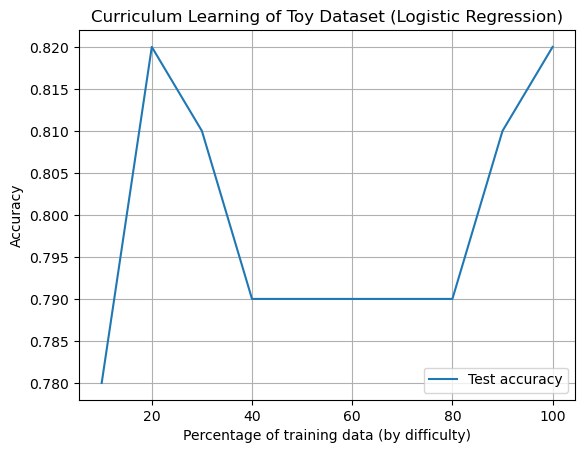

In [37]:
# plot results
plt.plot(difficulty_range * 100, test_accuracies_CL, label="Test accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Curriculum Learning of Toy Dataset (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

### (2) Self-Paced Learning

In Self-Paced Learning, the model is supposed to:

• learn from easier samples first (based on current loss)

• adaptively expand its training set to include harder samples as it becomes more confident

We will use the same X_train, X_test, y_train and y_test computed in the curriculum learning phase.
To implement the SPL we will introduce a difficulty threshold to let the model choose how many samples of this difficulty it is ready to handle.

/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_43553/772964653.py:47: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_pool)), y_pool])
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_43553/772964653.py:47: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_pool)), y_pool])
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_43553/772964653.py:47: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_pool)), y_pool])
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_43553/772964653.py:47: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_pool)), y_pool])
/var/folders/rl/9_bwtld11bj9ztyv7_8bh3280000gn/T/ipykernel_43553/772964653.py:47: RuntimeWarning: divide by zero encountered in log
  sample_losses = -np.log(probas[np.arange(len(y_pool)), y_pool])
/var/folde

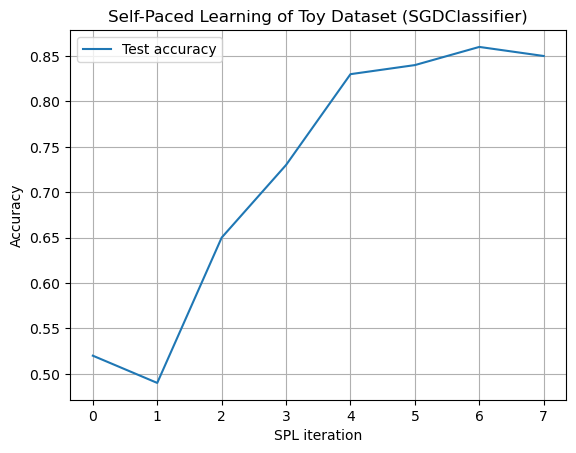

In [43]:
scaler = StandardScaler()
X_train_toy = scaler.fit_transform(X_train_toy)
X_test_toy = scaler.transform(X_test_toy)

classes = np.unique(y_toy)

# Grille de paramètres pour déterminer la meilleure combinaison SPL
lambda_t_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
lambda_growth_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
init_sizes = [50, 100, 150, 200, 250, 300]

max_iters = 10
results = {}

for lambda_t_init in lambda_t_values:
    for lambda_growth in lambda_growth_values:
        for init_size in init_sizes:
            np.random.seed(42)

            # Init SPL
            init_idx = np.random.choice(len(X_train), size=init_size, replace=True)
            X_curr = X_train[init_idx]
            y_curr = y_train[init_idx]

            mask = np.ones(len(X_train), dtype=bool)
            mask[init_idx] = False
            X_pool = X_train[mask]
            y_pool = y_train[mask]

            clf = SGDClassifier(loss="log_loss", random_state=42)
            clf.partial_fit(X_curr, y_curr, classes=classes)

            lambda_t = lambda_t_init
            train_accuracies = []
            test_accuracies = []

            # Accuracy
            init_acc = accuracy_score(y_test_toy, clf.predict(X_test_toy))
            test_accuracies.append(init_acc)
            train_accuracies.append(accuracy_score(y_curr, clf.predict(X_curr)))

            for it in range(max_iters):
                if len(X_pool) == 0:
                    break
                probas = clf.predict_proba(X_pool)
                sample_losses = -np.log(probas[np.arange(len(y_pool)), y_pool])
                easy_mask = sample_losses <= lambda_t

                if not np.any(easy_mask):
                    break

                X_easy = X_pool[easy_mask]
                y_easy = y_pool[easy_mask]

                X_curr = np.vstack([X_curr, X_easy])
                y_curr = np.concatenate([y_curr, y_easy])

                X_pool = X_pool[~easy_mask]
                y_pool = y_pool[~easy_mask]

                clf.partial_fit(X_easy, y_easy)

                train_acc = accuracy_score(y_curr, clf.predict(X_curr))
                test_acc = accuracy_score(y_test_toy, clf.predict(X_test_toy))

                train_accuracies.append(train_acc)
                test_accuracies.append(test_acc)

                lambda_t += lambda_growth

            test_accuracies = np.array(test_accuracies)
            acc_improvement = np.max(test_accuracies - init_acc)

            config = (lambda_t_init, lambda_growth, init_size)
            results[config] = {
                "train_acc": train_accuracies,
                "test_acc": test_accuracies,
                "init_acc": init_acc,
                "final_acc": test_accuracies[-1],
                "acc_improvement": acc_improvement
            }

(_, data_best) = max(results.items(), key=lambda x: x[1]["acc_improvement"])


plt.plot(data_best["test_acc"], label="Test accuracy")
plt.title(f"Self-Paced Learning of Toy Dataset (SGDClassifier)")
plt.xlabel("SPL iteration")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


### (3) Hard-Example Mining

Hard-Example Mining consists in feeding the model only hard examples. In our case, we will consider that a sample is difficult if its normalized difficulty is greater or equal than 0,75 (in other words the top 25%).

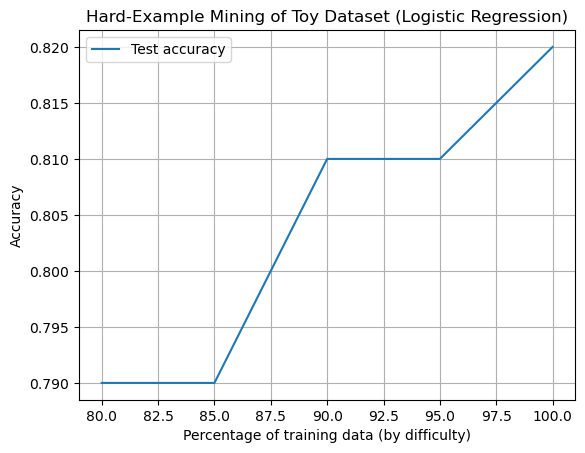

In [38]:
sorted_indices = np.argsort(norm_toy_difficulty)

X_sorted = X_train_toy[sorted_indices]
y_sorted = y_train_toy[sorted_indices]

percentages = np.linspace(0.8, 1, 5)
train_accuracies_HEM = []
test_accuracies_HEM = []


for percentage in percentages:
    n_samples = int(percentage * len(X_train_toy))
    X_train = X_train_toy[:n_samples]
    y_train = y_train_toy[:n_samples]
    
    clf = LogisticRegression()
    clf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test_toy, clf.predict(X_test_toy))
    
    train_accuracies_HEM.append(train_acc)
    test_accuracies_HEM.append(test_acc)
    
# Plot
plt.plot(percentages * 100, test_accuracies_HEM, label="Test accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Hard-Example Mining of Toy Dataset (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

### (4) Reverse Curriculum Learning

We are implementing **Reverse Curriculum Learning (RCL)** where the model starts learning from easier goals that are close to the target and gradually works backwards to more challenging starting states.

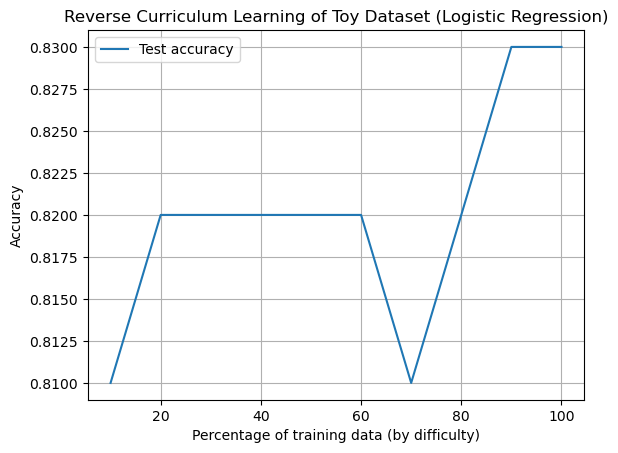

In [39]:
X_train_toy, X_test_toy, y_train_toy, y_test_toy = train_test_split(X_toy, y_toy, test_size=0.2, shuffle=True, random_state=42)

toy_difficulty = compute_toy_difficulty(X_train_toy)
norm_toy_difficulty = (toy_difficulty - toy_difficulty.min()) / (toy_difficulty.max() - toy_difficulty.min())
sorted_toy_indices = np.argsort(norm_toy_difficulty)[::-1] ## Reverse order for RCL

X_sorted = X_train_toy[sorted_toy_indices]
y_sorted = y_train_toy[sorted_toy_indices]

difficulty_range = np.linspace(0.1, 1.0, 10)
clf = LogisticRegression()

train_accuracies_RCL = []
test_accuracies_RCL = []

for percentage in difficulty_range:
    n_samples = int(percentage * len(X_train_toy))
    X_train = X_train_toy[:n_samples]
    y_train = y_train_toy[:n_samples]
    
    clf.fit(X_train, y_train)
    
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test_toy, clf.predict(X_test_toy))
    
    train_accuracies_RCL.append(train_acc)
    test_accuracies_RCL.append(test_acc)
    
plt.plot(difficulty_range * 100, test_accuracies_RCL, label="Test accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Reverse Curriculum Learning of Toy Dataset (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

### (5) Stratified Monte-Carlo Sampling

**Stratified Monte Carlo Sampling** is a variance reduction technique where the input space is divided into distinct strata (subregions), and samples are drawn from each stratum. This ensures more uniform coverage of the space compared to standard Monte Carlo sampling, leading to more accurate and stable estimates with fewer samples.

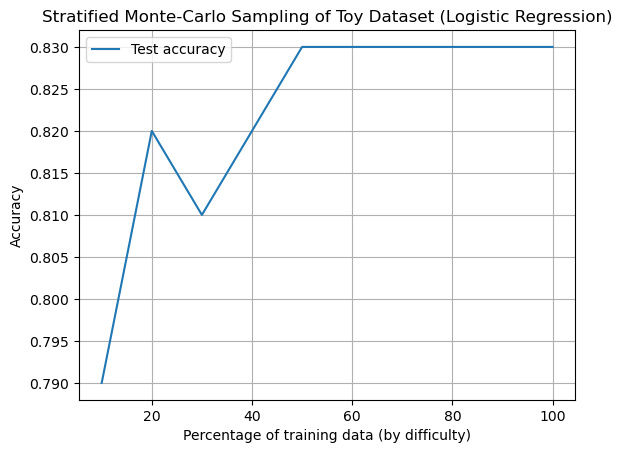

In [40]:
toy_difficulty = compute_toy_difficulty(X_train_toy)
norm_toy_difficulty = (toy_difficulty - toy_difficulty.min()) / (toy_difficulty.max() - toy_difficulty.min())

n_strata = 10
strata_bounds = np.linspace(0, 1, n_strata + 1)
strata_indices = [np.where((norm_toy_difficulty >= strata_bounds[i]) & 
                           (norm_toy_difficulty < strata_bounds[i + 1]))[0]
                  for i in range(n_strata)]

difficulty_range = np.linspace(0.1, 1.0, 10)
clf = LogisticRegression()

train_accuracies_SMC = []
test_accuracies_SMC = []

for percentage in difficulty_range:
    n_samples_total = int(percentage * len(X_train_toy))
    n_samples_per_stratum = n_samples_total // n_strata

    selected_indices = []

    for indices in strata_indices:
        if len(indices) == 0:
            continue
        stratum_sample = np.random.choice(indices, min(n_samples_per_stratum, len(indices)), replace=False)
        selected_indices.extend(stratum_sample)

    X_train = X_train_toy[selected_indices]
    y_train = y_train_toy[selected_indices]

    clf.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test_toy, clf.predict(X_test_toy))

    train_accuracies_SMC.append(train_acc)
    test_accuracies_SMC.append(test_acc)

plt.plot(difficulty_range * 100, test_accuracies_SMC, label="Test accuracy")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Stratified Monte-Carlo Sampling of Toy Dataset (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

# OVERALL GRAPHS

We create an overall graph regrouping the best performances of models on Toy Dataset.

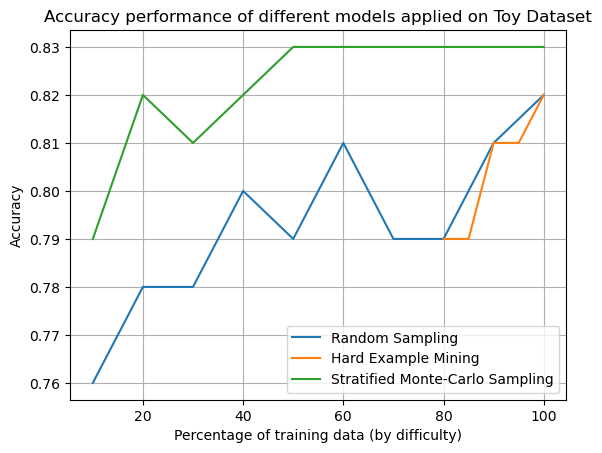

In [48]:
plt.plot(difficulty_range * 100, test_accuracies_base, label="Random Sampling")
plt.plot(percentages * 100, test_accuracies_HEM, label="Hard Example Mining")
plt.plot(difficulty_range * 100, test_accuracies_SMC, label="Stratified Monte-Carlo Sampling")
plt.xlabel("Percentage of training data (by difficulty)")
plt.ylabel("Accuracy")
plt.title("Accuracy performance of different models applied on Toy Dataset")
plt.legend()
plt.grid(True)
plt.show()